In [1]:
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Embedding, GRU, Merge, RepeatVector, TimeDistributed
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter
import numpy as np
import json
from IPython.display import SVG, display

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

Using Theano backend.


In [2]:
np.random.seed(13)
filters = base_filter() + "「」・。、（）？！　'"

In [3]:
# ja data
ja_docs = open("data/yellow.ja.txt").readlines()[0:20]
ja_tokenizer = Tokenizer(filters=filters)
ja_tokenizer.fit_on_texts(ja_docs)

ja_docs = ja_tokenizer.texts_to_sequences(ja_docs)

# en data
en_docs = open("data/yellow.en.txt").readlines()
en_docs = list(map(lambda x: "GOS " + x + " EOS" , en_docs))[0:20]
en_tokenizer = Tokenizer(filters=filters)
en_tokenizer.fit_on_texts(en_docs)
en_tokenizer.fit_on_texts(en_docs)

en_docs = en_tokenizer.texts_to_sequences(en_docs)

encoder_maxlen = max([len(x) for x in ja_docs])
decoder_maxlen = max([len(x)-1 for x in en_docs])
encoder_vocab_size = len(ja_tokenizer.word_index)+1
decoder_vocab_size = len(en_tokenizer.word_index)+1

In [4]:
def gen_training_data(X, Y, encoder_maxlen, decoder_maxlen, V, samples_size):
    encoder_inputs = []
    decoder_inputs = []
    next_words = []
    for i in range(len(X)):
        x_doc, y_doc = X[i], Y[i]
        for j in range(1, len(y_doc)):
            decoder_inputs.append(y_doc[0:j])
            next_words.append(y_doc[j])
            encoder_inputs.append(x_doc)
            if len(next_words) == samples_size:                
                labels = np_utils.to_categorical(next_words, V)
                encoder_inputs = sequence.pad_sequences(encoder_inputs, maxlen=encoder_maxlen)
                decoder_inputs = sequence.pad_sequences(decoder_inputs, maxlen=decoder_maxlen)
                yield ([encoder_inputs, decoder_inputs], labels)
                encoder_inputs = []
                decoder_inputs = []
                next_words = []
    labels = np_utils.to_categorical(next_words, V)
    encoder_inputs = sequence.pad_sequences(encoder_inputs, maxlen=encoder_maxlen)
    decoder_inputs = sequence.pad_sequences(decoder_inputs, maxlen=decoder_maxlen)

    yield ([encoder_inputs, decoder_inputs], labels)

In [5]:
encoder_maxlen = max([len(x) for x in ja_docs])
decoder_maxlen = max([len(x)-1 for x in en_docs])
encoder_vocab_size = len(ja_tokenizer.word_index)+1
decoder_vocab_size = len(en_tokenizer.word_index)+1

def gen_training_data(X, Y, encoder_maxlen, decoder_maxlen, V, samples_size):
    encoder_inputs = []
    decoder_inputs = []
    next_words = []
    for i in range(len(X)):
        x_doc, y_doc = X[i], Y[i]
        for j in range(1, len(y_doc)):
            decoder_inputs.append(y_doc[0:j])
            next_words.append(y_doc[j])
            encoder_inputs.append(x_doc)
            if len(next_words) == samples_size:                
                labels = np_utils.to_categorical(next_words, V)
                encoder_inputs = sequence.pad_sequences(encoder_inputs, maxlen=encoder_maxlen)
                decoder_inputs = sequence.pad_sequences(decoder_inputs, maxlen=decoder_maxlen)
                yield ([encoder_inputs, decoder_inputs], labels)
                encoder_inputs = []
                decoder_inputs = []
                next_words = []
    labels = np_utils.to_categorical(next_words, V)
    encoder_inputs = sequence.pad_sequences(encoder_inputs, maxlen=encoder_maxlen)
    decoder_inputs = sequence.pad_sequences(decoder_inputs, maxlen=decoder_maxlen)

    yield ([encoder_inputs, decoder_inputs], labels)

In [5]:
# encoder one doc to one repeated vector
encoder = Sequential()
encoder.add(Embedding(encoder_vocab_size, 128, input_length=encoder_maxlen))
encoder.add(GRU(128, return_sequences=False))
encoder.add(RepeatVector(decoder_maxlen))

# decoder inputs
decoder_input = Sequential()
decoder_input.add(Embedding(decoder_vocab_size, 128, input_length=decoder_maxlen))
decoder_input.add(GRU(output_dim=128, return_sequences=True))
decoder_input.add(TimeDistributed(Dense(128)))

model = Sequential()
model.add(Merge([encoder, decoder_input], mode='concat', concat_axis=-1))
model.add(GRU(128, return_sequences=False))
model.add(Dense(decoder_vocab_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta')

# save model without weights
with open('my_model.json', 'w') as f:
    json.dump(model.to_json(), f)


encoder


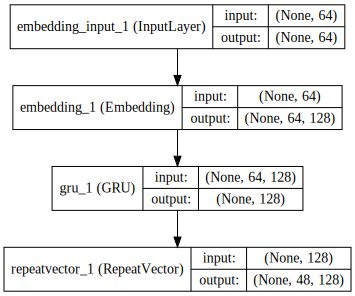

decoder input


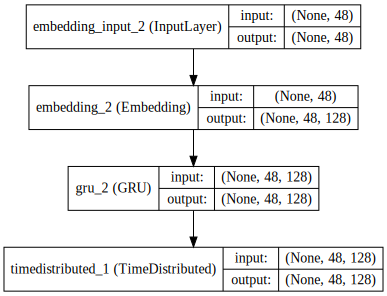

merge and decoder output


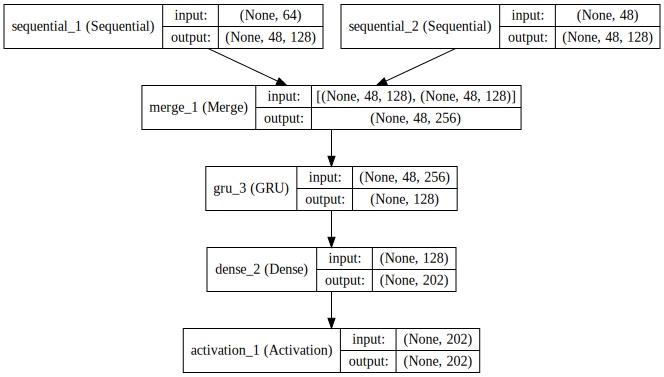

In [6]:
print("encoder")
display(SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg')))
print("decoder input")
display(SVG(model_to_dot(decoder_input, show_shapes=True).create(prog='dot', format='svg')))
print("merge and decoder output")
display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [7]:
for i in range(41):
        loss = 0.
        for x, y in gen_training_data(ja_docs, en_docs, encoder_maxlen, decoder_maxlen, decoder_vocab_size, 256):
            loss += model.train_on_batch(x, y)
        print(i, "loss ", loss)
        if not i % 10:
            model.save_weights('my_model_weights_' + str(i) + '.h5')

0 loss  10.5995488167
[WARNING] my_model_weights_0.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True in save_weights!
1 loss  10.5037736893
2 loss  10.3293170929
3 loss  9.95670461655
4 loss  9.83051872253
5 loss  9.70900392532
6 loss  9.65416717529
7 loss  9.60730791092
8 loss  9.57672786713
9 loss  9.55034828186
10 loss  9.52605104446
[WARNING] my_model_weights_10.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True in save_weights!
11 loss  9.50071525574
12 loss  9.47155475616
13 loss  9.43562889099
14 loss  9.39154243469
15 loss  9.34434461594
16 loss  9.31005525589
17 loss  9.25710010529
18 loss  9.17222213745
19 loss  9.19966316223
20 loss  9.05347681046
[WARNING] my_model_weights_20.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True in save_weights!
21 loss  9.00558805466
22 loss  8.97568321228
23 loss  8.86214637756
24 loss  8.80391693115
25 loss  8.75351142883
26 loss  8.67242074013
27 loss  8.6307072

In [8]:
# load model
model = model_from_json(json.load(open("./my_model.json")))

In [9]:
def sample(p):
    p /= sum(p)
    return np.where(np.random.multinomial(1,p,1)==1)[1][0]

In [10]:
encoder_words = "ホームズ は 答え た"
encoder_in = sequence.pad_sequences(ja_tokenizer.texts_to_sequences([encoder_words]), maxlen=encoder_maxlen)

for i in range(0, 41, 10):
    model.load_weights("./my_model_weights_" + str(i) + ".h5")
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')


    decoder_words = "gos"
    for _ in range(encoder_maxlen):
        decoder_in = sequence.pad_sequences(en_tokenizer.texts_to_sequences([decoder_words]),  maxlen=decoder_maxlen)
        wordid = sample(model.predict([encoder_in, decoder_in])[0])
        
        for k, v in en_tokenizer.word_index.items():
            if v == wordid:
                decoder_words += " " + k
                break
        if k == "eos":
            break

    print(i, decoder_words.replace("gos", "").replace("eos", ""))

0  but simple turned gifts my me protest it occasional turned it musgrave versatility the relaxed far in remarkable musgrave interest successes adventure go cases most weight their of capable relaxed singular circumstances my habits tale too without for conan adventure actors had companion then singular leaves monotony weight have untiring half left at relaxed sparest versatility day so first actors drama his effort my
10  in sparest the was a a the the papers dozen he energy and the because indefatigable have no turned short in was undoubtedly versatility that 
20  and for for for but bodily as that the of use when weight 
30  the the present are save seldom faint of that he out out that a walk and a existence save holmes heads the their 
40  the had who the of use to habits were of and the remarkable the sticky to heads natural beginning were uninteresting their some just 
